# descriptive stats on data

- it became clear from the feature engineering and trying to run a simple linear model that the size of the data is cumbersome

- moved from ml.m52xlarget to ml.m5.4xlarge

- the number of observations in the test data is 15 days
- in the training it was 1687 days


- we have established that the items have to be pooled in some way to account for the sparsity of observations for some items
    * at least for all stores and likely by item grouping
   
- model is regression based models , gradient boosted decision trees according to learnings from kaggle forecasting competitions (Bojer and Meldgaard)

- neural networks
    
    

# stratification for modelling
- start with the simplest which is regression by item pooled across store
- indicator for has the item been sold in this store previously


- given time constraints am going to run lstm neural network model 
- with multioutput 
-

reference: 
- https://machinelearningmastery.com/multi-output-regression-models-with-python/ 
- https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/
- https://www.tensorflow.org/tutorials/structured_data/time_series
Chollet

In [1]:
import pandas as pd
import numpy as np

In [ ]:
%%time
df_train = pd.read_feather("data/trainpy.feather")
df_test = pd.read_csv("data/test.csv") 

In [ ]:
df_train.head()

In [4]:
train_items = df_train['item_nbr'].unique()
test_items = df_test['item_nbr'].unique()

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
 
items = intersection(train_items, test_items)
print(len(items))

#https://realpython.com/python-sets/
items_not_in_train = list(set(test_items).difference(train_items))
items_not_in_test = list(set(train_items).difference(test_items))
print("items not in train:", len(items_not_in_train))
print("items not in test (ignore):", len(items_not_in_test))

items not in train: 60
items not in test (ignore): 195


In [5]:
pd.DataFrame(items, columns=['item_nbr']).to_csv("items/items_both.csv", index=False)
pd.DataFrame(items_not_in_train, columns=['item_nbr']).to_csv("items/items_not_in_train.csv", index=False)

In [6]:
from random import sample
item = sample(items,1)[0]
item

1463789

In [8]:
df_train_i = df_train[df_train['item_nbr'] == 1956004]
df_test_i = df_test[df_test['item_nbr'] == 1956004]
df_train_i.to_csv("df_train.csv", index=False)
df_test_i.to_csv("df_test.csv", index=False)

print(df_train_i.shape)
data = pd.concat([df_train_i, df_test_i])

data.to_csv("data.csv", index=False)

(11840, 6)


In [8]:
data.shape
len(data['store_nbr'].unique())
data

id        date  store_nbr  item_nbr  unit_sales onpromotion
67433669   67433669  2016-01-12          7   1956004         4.0       False
67613006   67613006  2016-01-14          7   1956004         6.0       False
67638493   67638493  2016-01-14         24   1956004         6.0       False
67675626   67675626  2016-01-14         47   1956004         5.0       False
67701435   67701435  2016-01-15          7   1956004         2.0       False
...             ...         ...        ...       ...         ...         ...
3354062   128851102  2017-08-31         50   1956004         NaN       False
3357963   128855003  2017-08-31         51   1956004         NaN        True
3361864   128858904  2017-08-31         52   1956004         NaN        True
3365765   128862805  2017-08-31         53   1956004         NaN       False
3369666   128866706  2017-08-31         54   1956004         NaN       False

[12704 rows x 6 columns]

In [9]:
dt = data.pivot(values='unit_sales', index=['date'], columns='store_nbr')
dt.shape
dt.shape[0] * dt.shape[1]

32130

In [10]:
df = dt.fillna(0)
print(df.columns)
df.index = pd.to_datetime(df.index)
df

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54],
           dtype='int64', name='store_nbr')


store_nbr    1    2    3    4    5    6    7    8    9    10  ...   45   46  \
date                                                          ...             
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-14  0.0  0.0  0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-15  0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-16  0.0  0.0  0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  ...  0.0  0.0   
2016-01-17  0.0  0.0  7.0  0.0  4.0  0.0  2.0  0.0  0.0  0.0  ...  0.0  0.0   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

store_nbr    47   48   49   50   51   52   53   54  
date                                                
2016-01-12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-14  5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-15  2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-16  4.0  6.0  0.0  0.0  0.0  0.0  0.0  0.0  
2016-01-17  6.0  9.0  0.0  0.0  0.0  0.0  0.0  0.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2017-08-27  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-28  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-29  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-30  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2017-08-31  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[595 rows x 54 columns]

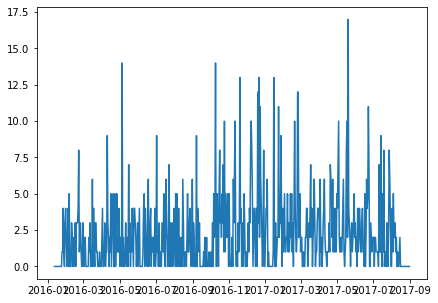

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))


plt.plot(df[1].index, df[1].values)

In [12]:
from datetime import datetime 
cutoff = datetime.strptime('2017-08-16', "%Y-%m-%d")
df = df.loc[df.index < cutoff, :]
dfv = df.values
print(dfv.shape)
dfv

(579, 54)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  7.,  8., ..., 19.,  0.,  0.],
       [ 1.,  3.,  7., ...,  6.,  0.,  0.],
       [ 2.,  1., 10., ..., 12.,  0.,  0.]])

In [13]:
df

store_nbr    1    2     3    4    5    6    7    8    9    10  ...   45    46  \
date                                                           ...              
2016-01-12  0.0  0.0   0.0  0.0  0.0  0.0  4.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-14  0.0  0.0   0.0  0.0  0.0  0.0  6.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-15  0.0  0.0   0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-16  0.0  0.0   0.0  0.0  0.0  0.0  5.0  0.0  0.0  0.0  ...  0.0   0.0   
2016-01-17  0.0  0.0   7.0  0.0  4.0  0.0  2.0  0.0  0.0  0.0  ...  0.0   0.0   
...         ...  ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
2017-08-11  1.0  2.0  19.0  0.0  1.0  5.0  2.0  0.0  0.0  0.0  ...  6.0  21.0   
2017-08-12  0.0  1.0  17.0  0.0  2.0  2.0  0.0  0.0  0.0  0.0  ...  9.0  11.0   
2017-08-13  0.0  7.0   8.0  0.0  2.0  6.0  0.0  3.0  0.0  0.0  ...  9.0  26.0   
2017-08-14  1.0  3.0   7.0  0.0  1.0  4.0  0.0  1.0  0.0  0.0  ...  9.0  18.0   
2017-08-15  2.0  1.0  10.0  0.0  2.0  7.0  1.0  3.0  0.0  0.0  ...  1.0  23.0   

store_nbr     47    48   49   50   51    52   53   54  
date                                                   
2016-01-12   0.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-14   5.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-15   2.0   0.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-16   4.0   6.0  0.0  0.0  0.0   0.0  0.0  0.0  
2016-01-17   6.0   9.0  0.0  0.0  0.0   0.0  0.0  0.0  
...          ...   ...  ...  ...  ...   ...  ...  ...  
2017-08-11   8.0  10.0  2.0  0.0  5.0  10.0  0.0  0.0  
2017-08-12  11.0  14.0  4.0  0.0  3.0  13.0  0.0  0.0  
2017-08-13   9.0  13.0  3.0  0.0  6.0  19.0  0.0  0.0  
2017-08-14  10.0   8.0  3.0  0.0  4.0   6.0  0.0  0.0  
2017-08-15   2.0  15.0  3.0  0.0  5.0  12.0  0.0  0.0  

[579 rows x 54 columns]

In [14]:
"""
start_index: usually 0
end_index: Train Split
history_size: window (lags)
target_size: how far into future
"""

'\nstart_index: usually 0\nend_index: Train Split\nhistory_size: window (lags)\ntarget_size: how far into future\n'

In [15]:
dfv[50-50:50]

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 3.,  0., 13., ...,  0.,  1.,  0.],
       [ 1.,  1.,  3., ...,  0.,  0.,  0.],
       [ 0.,  1.,  4., ...,  0.,  0.,  0.]])

In [16]:
def create_data_v(data, lags, start, end, target_size):
  x_data = []
  y_data = [] 
  index = [i for i in range(0, len(data))]

  for i in range(start, end):
    x_data.append(data[i-lags:i])
    y_data.append(data[i:i+target_size])
    if (i < start + 5) or (i >= end - 5):
      print("i: %s (%s), x: %s-%s, y: %s-%s" % (i, dt.index[index[i]], i-lags, i-1, i, i+target_size))

  print(f"start: {start}, end: {end}, lags: {lags}, target_size {target_size}")
  return(np.array(x_data), np.array(y_data))

In [17]:
#taking a split of 80/20
split = int(len(dfv) * 0.8)
split

463

In [18]:
# create data for X and y train 

lags = 50
start = lags
end = split
target_size = 15

X_train, y_train = create_data_v(dfv, lags, start, end, target_size)

i: 50 (2016-03-03), x: 0-49, y: 50-65
i: 51 (2016-03-04), x: 1-50, y: 51-66
i: 52 (2016-03-05), x: 2-51, y: 52-67
i: 53 (2016-03-06), x: 3-52, y: 53-68
i: 54 (2016-03-07), x: 4-53, y: 54-69
i: 458 (2017-04-17), x: 408-457, y: 458-473
i: 459 (2017-04-18), x: 409-458, y: 459-474
i: 460 (2017-04-19), x: 410-459, y: 460-475
i: 461 (2017-04-20), x: 411-460, y: 461-476
i: 462 (2017-04-21), x: 412-461, y: 462-477
start: 50, end: 463, lags: 50, target_size 15


In [19]:
y_train.shape
X_train.shape

(413, 50, 54)

In [20]:
# create data for X and y test sets

start = split
end = len(dfv) - target_size

X_test, y_test = create_data_v(dfv, lags, start, end, target_size)

i: 463 (2017-04-22), x: 413-462, y: 463-478
i: 464 (2017-04-23), x: 414-463, y: 464-479
i: 465 (2017-04-24), x: 415-464, y: 465-480
i: 466 (2017-04-25), x: 416-465, y: 466-481
i: 467 (2017-04-26), x: 417-466, y: 467-482
i: 559 (2017-07-27), x: 509-558, y: 559-574
i: 560 (2017-07-28), x: 510-559, y: 560-575
i: 561 (2017-07-29), x: 511-560, y: 561-576
i: 562 (2017-07-30), x: 512-561, y: 562-577
i: 563 (2017-07-31), x: 513-562, y: 563-578
start: 463, end: 564, lags: 50, target_size 15


In [21]:
print(y_test.shape)
print(X_test.shape)

(101, 15, 54)
(101, 50, 54)


In [22]:
import sklearn.linear_model as lm
m = lm.LinearRegression()


In [23]:
print(X_train.shape[0])
X_train[0].shape[0]

print(y_train.shape)
print(X_train.shape)
#y_train.reshape(1, -1)[0].shape
print(X_test.shape)
print(y_test.shape)

413
(413, 15, 54)
(413, 50, 54)
(101, 50, 54)
(101, 15, 54)


In [24]:
xt = pd.DataFrame()
yt = pd.DataFrame()

for i in range(0, X_train.shape[0]):
    xt = xt.append(pd.DataFrame(X_train[i].T))
    yt = yt.append(pd.DataFrame(y_train[i].T))

print(xt.shape)
print(yt.shape)


(22302, 50)
(22302, 15)


In [25]:
xt.shape[0] * xt.shape[1]

1115100

In [26]:
m.fit(xt, yt)

LinearRegression()

In [27]:
xtt = pd.DataFrame()
ytt = pd.DataFrame()

predictions = list()

for i in range(0, X_test.shape[0]):
    xtt = xtt.append(pd.DataFrame(X_test[i].T))
    ytt = ytt.append(pd.DataFrame(y_test[i].T))

    
print(xtt.shape)
print(ytt.shape)

preds = m.predict(xtt)

preds

(5454, 50)
(5454, 15)


array([[3.45532807, 2.66895892, 2.72166743, ..., 2.7952674 , 3.00468838,
        2.72881763],
       [3.2662842 , 3.98986494, 2.79220801, ..., 2.70108885, 2.34900344,
        3.12508922],
       [9.09272241, 9.19393608, 7.76847745, ..., 8.01641079, 8.873094  ,
        8.82470502],
       ...,
       [8.39846614, 6.43897299, 6.28165318, ..., 8.55902421, 9.22621849,
        8.02913983],
       [0.04262057, 0.05401615, 0.05470976, ..., 0.09194146, 0.11279986,
        0.1074576 ],
       [0.04577267, 0.05577353, 0.06287951, ..., 0.09417081, 0.09463446,
        0.09958854]])

In [28]:
print(preds.shape)
ytt.shape

(5454, 15)


(5454, 15)

In [29]:
pdf = pd.DataFrame(preds)
pdf

0         1         2         3         4         5         6   \
0     3.455328  2.668959  2.721667  2.631912  2.210616  2.803931  2.957300   
1     3.266284  3.989865  2.792208  1.722440  1.961441  2.190702  2.562211   
2     9.092722  9.193936  7.768477  6.660914  7.966974  7.451388  8.819107   
3     6.849252  7.446820  4.645374  3.489023  5.346633  4.758837  4.142443   
4     1.179919  0.845916  0.556742  0.859988  1.347471  1.347085  1.297165   
...        ...       ...       ...       ...       ...       ...       ...   
5449  0.045773  0.055774  0.062880  0.068083  0.071156  0.075014  0.075807   
5450  4.146578  3.740698  5.200516  5.067878  4.901851  4.983184  4.521761   
5451  8.398466  6.438973  6.281653  6.045588  7.828572  9.467794  8.642504   
5452  0.042621  0.054016  0.054710  0.125394  0.094456  0.060669  0.080385   
5453  0.045773  0.055774  0.062880  0.068083  0.071156  0.075014  0.075807   

            7         8         9         10        11        12        13  \
0     2.802374  2.189653  2.508346  2.307035  2.171869  2.795267  3.004688   
1     2.893038  3.957225  2.222381  1.448782  1.579875  2.701089  2.349003   
2     8.647117  9.509717  7.227113  6.395967  8.081599  8.016411  8.873094   
3     7.177820  7.591870  4.544955  3.702256  4.979834  4.847002  4.256472   
4     1.149276  1.067563  0.759382  0.824695  1.426642  1.550484  1.377210   
...        ...       ...       ...       ...       ...       ...       ...   
5449  0.082159  0.086689  0.089398  0.090569  0.092658  0.094171  0.094634   
5450  4.069540  3.577804  6.078956  5.324248  4.662324  4.910247  4.544162   
5451  8.128689  6.087950  6.581444  6.043662  7.790344  8.559024  9.226218   
5452  0.106007  0.098024  0.116784  0.162572  0.118395  0.091941  0.112800   
5453  0.082159  0.086689  0.089398  0.090569  0.092658  0.094171  0.094634   

            14  
0     2.728818  
1     3.125089  
2     8.824705  
3     6.801305  
4     1.210424  
...        ...  
5449  0.099589  
5450  2.976548  
5451  8.029140  
5452  0.107458  
5453  0.099589  

[5454 rows x 15 columns]

In [113]:
ytt

0     1    2     3     4     5     6     7    8    9    10    11    12  \
0   5.0   2.0  6.0   1.0   4.0   1.0   1.0   4.0  1.0  5.0  4.0   7.0  10.0   
1   5.0   1.0  2.0   0.0   4.0   2.0   2.0   1.0  1.0  3.0  1.0  11.0   1.0   
2   9.0  11.0  3.0   1.0   1.0  11.0   4.0   2.0  5.0  7.0  7.0  19.0   3.0   
3   5.0   5.0  8.0   7.0  12.0   3.0   1.0   3.0  4.0  4.0  4.0   6.0   4.0   
4   1.0   0.0  0.0   0.0   0.0   0.0   0.0   3.0  4.0  0.0  0.0   3.0   0.0   
..  ...   ...  ...   ...   ...   ...   ...   ...  ...  ...  ...   ...   ...   
49  0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
50  4.0   1.0  8.0   1.0   7.0   5.0   6.0   3.0  6.0  7.0  4.0   5.0   3.0   
51  8.0   8.0  4.0  11.0   9.0   7.0  11.0  11.0  8.0  8.0  5.0  10.0  13.0   
52  0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
53  0.0   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   

      13    14  
0    2.0   1.0  
1    2.0   4.0  
2    5.0   5.0  
3    0.0  12.0  
4    3.0   0.0  
..   ...   ...  
49   0.0   0.0  
50   6.0   4.0  
51  19.0   6.0  
52   0.0   0.0  
53   0.0   0.0  

[5454 rows x 15 columns]

In [31]:
np.mean(np.abs(pdf.values - ytt.values))

1.4315223143407563

In [32]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor()
m.fit(xt, yt)

preds = m.predict(xtt)

preds
pdf = pd.DataFrame(preds)
np.mean(np.abs(pdf.values - ytt.values))

1.9973314912424411

In [33]:
dlist = pd.DataFrame(df.index)
dlist.shape

(579, 1)

In [34]:
df.head()
df.columns
dfd = np.zeros(df.shape).astype(datetime)

dfd[0,0]
for i in range(0, df.shape[0]):
  for j in range(0, df.shape[1]):
    dfd[i,j] = str(dlist['date'][i])
dfd = pd.DataFrame(dfd) 
print(dfd.shape)
dfd.tail()

(579, 54)


0                    1                    2   \
574  2017-08-11 00:00:00  2017-08-11 00:00:00  2017-08-11 00:00:00   
575  2017-08-12 00:00:00  2017-08-12 00:00:00  2017-08-12 00:00:00   
576  2017-08-13 00:00:00  2017-08-13 00:00:00  2017-08-13 00:00:00   
577  2017-08-14 00:00:00  2017-08-14 00:00:00  2017-08-14 00:00:00   
578  2017-08-15 00:00:00  2017-08-15 00:00:00  2017-08-15 00:00:00   

                      3                    4                    5   \
574  2017-08-11 00:00:00  2017-08-11 00:00:00  2017-08-11 00:00:00   
575  2017-08-12 00:00:00  2017-08-12 00:00:00  2017-08-12 00:00:00   
576  2017-08-13 00:00:00  2017-08-13 00:00:00  2017-08-13 00:00:00   
577  2017-08-14 00:00:00  2017-08-14 00:00:00  2017-08-14 00:00:00   
578  2017-08-15 00:00:00  2017-08-15 00:00:00  2017-08-15 00:00:00   

                      6                    7                    8   \
574  2017-08-11 00:00:00  2017-08-11 00:00:00  2017-08-11 00:00:00   
575  2017-08-12 00:00:00  2017-08-12 00:00:00  2017-08-12 00:00:00   
576  2017-08-13 00:00:00  2017-08-13 00:00:00  2017-08-13 00:00:00   
577  2017-08-14 00:00:00  2017-08-14 00:00:00  2017-08-14 00:00:00   
578  2017-08-15 00:00:00  2017-08-15 00:00:00  2017-08-15 00:00:00   

                      9   ...                   44                   45  \
574  2017-08-11 00:00:00  ...  2017-08-11 00:00:00  2017-08-11 00:00:00   
575  2017-08-12 00:00:00  ...  2017-08-12 00:00:00  2017-08-12 00:00:00   
576  2017-08-13 00:00:00  ...  2017-08-13 00:00:00  2017-08-13 00:00:00   
577  2017-08-14 00:00:00  ...  2017-08-14 00:00:00  2017-08-14 00:00:00   
578  2017-08-15 00:00:00  ...  2017-08-15 00:00:00  2017-08-15 00:00:00   

                      46                   47                   48  \
574  2017-08-11 00:00:00  2017-08-11 00:00:00  2017-08-11 00:00:00   
575  2017-08-12 00:00:00  2017-08-12 00:00:00  2017-08-12 00:00:00   
576  2017-08-13 00:00:00  2017-08-13 00:00:00  2017-08-13 00:00:00   
577  2017-08-14 00:00:00  2017-08-14 00:00:00  2017-08-14 00:00:00   
578  2017-08-15 00:00:00  2017-08-15 00:00:00  2017-08-15 00:00:00   

                      49                   50                   51  \
574  2017-08-11 00:00:00  2017-08-11 00:00:00  2017-08-11 00:00:00   
575  2017-08-12 00:00:00  2017-08-12 00:00:00  2017-08-12 00:00:00   
576  2017-08-13 00:00:00  2017-08-13 00:00:00  2017-08-13 00:00:00   
577  2017-08-14 00:00:00  2017-08-14 00:00:00  2017-08-14 00:00:00   
578  2017-08-15 00:00:00  2017-08-15 00:00:00  2017-08-15 00:00:00   

                      52                   53  
574  2017-08-11 00:00:00  2017-08-11 00:00:00  
575  2017-08-12 00:00:00  2017-08-12 00:00:00  
576  2017-08-13 00:00:00  2017-08-13 00:00:00  
577  2017-08-14 00:00:00  2017-08-14 00:00:00  
578  2017-08-15 00:00:00  2017-08-15 00:00:00  

[5 rows x 54 columns]

In [35]:
def create_dates(data, lags, start, end, target_size):
  x_dates = []
  y_dates = []

  index = [i for i in range(0, len(data))]

  for i in range(start, end):
    x_dates.append(data[i-lags:i])
    y_dates.append(data[i:i+target_size])
    if (i < start + 5) or (i >= end - 5):
      print("i: %s (%s), x: %s-%s, y: %s-%s" % (i, dt.index[index[i]], i-lags, i-1, i, i+target_size))

  print(f"start: {start}, end: {end}, lags: {lags}, target_size {target_size}")
  return(np.array(x_dates), np.array(y_dates))

In [36]:
# create dates for test set

start = split
end = len(dfv) - target_size

X_dates, y_dates = create_dates(dfd, lags, start, end, target_size)

i: 463 (2017-04-22), x: 413-462, y: 463-478
i: 464 (2017-04-23), x: 414-463, y: 464-479
i: 465 (2017-04-24), x: 415-464, y: 465-480
i: 466 (2017-04-25), x: 416-465, y: 466-481
i: 467 (2017-04-26), x: 417-466, y: 467-482
i: 559 (2017-07-27), x: 509-558, y: 559-574
i: 560 (2017-07-28), x: 510-559, y: 560-575
i: 561 (2017-07-29), x: 511-560, y: 561-576
i: 562 (2017-07-30), x: 512-561, y: 562-577
i: 563 (2017-07-31), x: 513-562, y: 563-578
start: 463, end: 564, lags: 50, target_size 15


In [37]:
print(X_dates.shape)
print(y_dates.shape)
print(X_test.shape)
print(y_test.shape)

(101, 50, 54)
(101, 15, 54)
(101, 50, 54)
(101, 15, 54)


In [38]:
pd.DataFrame(y_dates[0].T).head()

0                    1                    2   \
0  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
1  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
2  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
3  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
4  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   

                    3                    4                    5   \
0  2017-04-25 00:00:00  2017-04-26 00:00:00  2017-04-27 00:00:00   
1  2017-04-25 00:00:00  2017-04-26 00:00:00  2017-04-27 00:00:00   
2  2017-04-25 00:00:00  2017-04-26 00:00:00  2017-04-27 00:00:00   
3  2017-04-25 00:00:00  2017-04-26 00:00:00  2017-04-27 00:00:00   
4  2017-04-25 00:00:00  2017-04-26 00:00:00  2017-04-27 00:00:00   

                    6                    7                    8   \
0  2017-04-28 00:00:00  2017-04-29 00:00:00  2017-04-30 00:00:00   
1  2017-04-28 00:00:00  2017-04-29 00:00:00  2017-04-30 00:00:00   
2  2017-04-28 00:00:00  2017-04-29 00:00:00  2017-04-30 00:00:00   
3  2017-04-28 00:00:00  2017-04-29 00:00:00  2017-04-30 00:00:00   
4  2017-04-28 00:00:00  2017-04-29 00:00:00  2017-04-30 00:00:00   

                    9                    10                   11  \
0  2017-05-01 00:00:00  2017-05-02 00:00:00  2017-05-03 00:00:00   
1  2017-05-01 00:00:00  2017-05-02 00:00:00  2017-05-03 00:00:00   
2  2017-05-01 00:00:00  2017-05-02 00:00:00  2017-05-03 00:00:00   
3  2017-05-01 00:00:00  2017-05-02 00:00:00  2017-05-03 00:00:00   
4  2017-05-01 00:00:00  2017-05-02 00:00:00  2017-05-03 00:00:00   

                    12                   13                   14  
0  2017-05-04 00:00:00  2017-05-05 00:00:00  2017-05-06 00:00:00  
1  2017-05-04 00:00:00  2017-05-05 00:00:00  2017-05-06 00:00:00  
2  2017-05-04 00:00:00  2017-05-05 00:00:00  2017-05-06 00:00:00  
3  2017-05-04 00:00:00  2017-05-05 00:00:00  2017-05-06 00:00:00  
4  2017-05-04 00:00:00  2017-05-05 00:00:00  2017-05-06 00:00:00

In [39]:
pd.DataFrame(X_dates[0].T).head()

0                    1                    2   \
0  2017-03-03 00:00:00  2017-03-04 00:00:00  2017-03-05 00:00:00   
1  2017-03-03 00:00:00  2017-03-04 00:00:00  2017-03-05 00:00:00   
2  2017-03-03 00:00:00  2017-03-04 00:00:00  2017-03-05 00:00:00   
3  2017-03-03 00:00:00  2017-03-04 00:00:00  2017-03-05 00:00:00   
4  2017-03-03 00:00:00  2017-03-04 00:00:00  2017-03-05 00:00:00   

                    3                    4                    5   \
0  2017-03-06 00:00:00  2017-03-07 00:00:00  2017-03-08 00:00:00   
1  2017-03-06 00:00:00  2017-03-07 00:00:00  2017-03-08 00:00:00   
2  2017-03-06 00:00:00  2017-03-07 00:00:00  2017-03-08 00:00:00   
3  2017-03-06 00:00:00  2017-03-07 00:00:00  2017-03-08 00:00:00   
4  2017-03-06 00:00:00  2017-03-07 00:00:00  2017-03-08 00:00:00   

                    6                    7                    8   \
0  2017-03-09 00:00:00  2017-03-10 00:00:00  2017-03-11 00:00:00   
1  2017-03-09 00:00:00  2017-03-10 00:00:00  2017-03-11 00:00:00   
2  2017-03-09 00:00:00  2017-03-10 00:00:00  2017-03-11 00:00:00   
3  2017-03-09 00:00:00  2017-03-10 00:00:00  2017-03-11 00:00:00   
4  2017-03-09 00:00:00  2017-03-10 00:00:00  2017-03-11 00:00:00   

                    9   ...                   40                   41  \
0  2017-03-12 00:00:00  ...  2017-04-12 00:00:00  2017-04-13 00:00:00   
1  2017-03-12 00:00:00  ...  2017-04-12 00:00:00  2017-04-13 00:00:00   
2  2017-03-12 00:00:00  ...  2017-04-12 00:00:00  2017-04-13 00:00:00   
3  2017-03-12 00:00:00  ...  2017-04-12 00:00:00  2017-04-13 00:00:00   
4  2017-03-12 00:00:00  ...  2017-04-12 00:00:00  2017-04-13 00:00:00   

                    42                   43                   44  \
0  2017-04-14 00:00:00  2017-04-15 00:00:00  2017-04-16 00:00:00   
1  2017-04-14 00:00:00  2017-04-15 00:00:00  2017-04-16 00:00:00   
2  2017-04-14 00:00:00  2017-04-15 00:00:00  2017-04-16 00:00:00   
3  2017-04-14 00:00:00  2017-04-15 00:00:00  2017-04-16 00:00:00   
4  2017-04-14 00:00:00  2017-04-15 00:00:00  2017-04-16 00:00:00   

                    45                   46                   47  \
0  2017-04-17 00:00:00  2017-04-18 00:00:00  2017-04-19 00:00:00   
1  2017-04-17 00:00:00  2017-04-18 00:00:00  2017-04-19 00:00:00   
2  2017-04-17 00:00:00  2017-04-18 00:00:00  2017-04-19 00:00:00   
3  2017-04-17 00:00:00  2017-04-18 00:00:00  2017-04-19 00:00:00   
4  2017-04-17 00:00:00  2017-04-18 00:00:00  2017-04-19 00:00:00   

                    48                   49  
0  2017-04-20 00:00:00  2017-04-21 00:00:00  
1  2017-04-20 00:00:00  2017-04-21 00:00:00  
2  2017-04-20 00:00:00  2017-04-21 00:00:00  
3  2017-04-20 00:00:00  2017-04-21 00:00:00  
4  2017-04-20 00:00:00  2017-04-21 00:00:00  

[5 rows x 50 columns]

In [40]:
xtd = pd.DataFrame()
ytd = pd.DataFrame()

for i in range(0, X_dates.shape[0]):
    xtd = xtd.append(pd.DataFrame(X_dates[i].T))
    ytd = ytd.append(pd.DataFrame(y_dates[i].T))

print(xtd.shape)
print(ytd.shape)
print(xtt.shape)
print(ytt.shape)


(5454, 50)
(5454, 15)
(5454, 50)
(5454, 15)


In [41]:
print(xtt.shape[0])
ytt.tail()

5454


0    1    2     3    4    5     6     7    8    9    10    11    12  \
49  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
50  4.0  1.0  8.0   1.0  7.0  5.0   6.0   3.0  6.0  7.0  4.0   5.0   3.0   
51  8.0  8.0  4.0  11.0  9.0  7.0  11.0  11.0  8.0  8.0  5.0  10.0  13.0   
52  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   
53  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   0.0   0.0   

      13   14  
49   0.0  0.0  
50   6.0  4.0  
51  19.0  6.0  
52   0.0  0.0  
53   0.0  0.0

In [42]:
pd.DataFrame(preds).tail()

0         1          2         3        4         5         6   \
5449   0.004349  0.007846   0.011533  0.017206  0.01938  0.022027  0.024674   
5450  11.000000  9.000000  11.000000  4.000000  2.00000  3.000000  1.000000   
5451  10.000000  2.000000   2.000000  6.000000  1.00000  4.000000  3.000000   
5452   0.000000  0.000000   0.000000  0.000000  0.00000  0.000000  0.000000   
5453   0.004349  0.007846   0.011533  0.017206  0.01938  0.022027  0.024674   

            7        8         9         10         11        12         13  \
5449  0.026565  0.02855  0.030346  0.033182   0.035167  0.038003   0.040745   
5450  5.000000  2.00000  2.000000  0.000000  12.000000  4.000000  10.000000   
5451  8.000000  2.00000  6.000000  1.000000   1.000000  6.000000   2.000000   
5452  0.000000  0.00000  0.000000  0.000000   0.000000  0.000000   0.000000   
5453  0.026565  0.02855  0.030346  0.033182   0.035167  0.038003   0.040745   

            14  
5449  0.043203  
5450  7.000000  
5451  1.000000  
5452  0.000000  
5453  0.043203

yhatdf = pd.Dataframe(columns=['date','item_nbr','store_nbr'])

for r in range(ytt.shape[0]):
    print((r % 54) + 1)
    yhatdf[r] = [ytt[]

In [57]:
ytd[0] == "2017-04-22 00:00:00"

0      True
1      True
2      True
3      True
4      True
      ...  
49    False
50    False
51    False
52    False
53    False
Name: 0, Length: 5454, dtype: bool

In [65]:
ytd.reset_index(inplace=True)

In [70]:
ytd[53:55]

index                    0                    1                    2  \
53     53  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
54      0  2017-04-23 00:00:00  2017-04-24 00:00:00  2017-04-25 00:00:00   

                      3                    4                    5  \
53  2017-04-25 00:00:00  2017-04-26 00:00:00  2017-04-27 00:00:00   
54  2017-04-26 00:00:00  2017-04-27 00:00:00  2017-04-28 00:00:00   

                      6                    7                    8  \
53  2017-04-28 00:00:00  2017-04-29 00:00:00  2017-04-30 00:00:00   
54  2017-04-29 00:00:00  2017-04-30 00:00:00  2017-05-01 00:00:00   

                      9                   10                   11  \
53  2017-05-01 00:00:00  2017-05-02 00:00:00  2017-05-03 00:00:00   
54  2017-05-02 00:00:00  2017-05-03 00:00:00  2017-05-04 00:00:00   

                     12                   13                   14  
53  2017-05-04 00:00:00  2017-05-05 00:00:00  2017-05-06 00:00:00  
54  2017-05-05 00:00:00  2017-05-06 00:00:00  2017-05-07 00:00:00

In [214]:
from datetime import datetime
result = ytd.loc[(ytd[0] == "2017-04-22 00:00:00"),:]
result.rename(columns={'index':'store'}, inplace=True)
result

store                    0                    1                    2  \
0       0  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
1       1  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
2       2  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
3       3  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
4       4  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
5       5  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
6       6  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
7       7  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
8       8  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
9       9  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
10     10  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
11     11  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
12     12  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
13     13  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
14     14  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
15     15  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
16     16  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
17     17  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
18     18  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
19     19  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
20     20  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
21     21  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
22     22  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
23     23  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
24     24  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
25     25  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
26     26  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
27     27  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
28     28  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
29     29  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
30     30  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
31     31  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
32     32  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
33     33  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
34     34  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
35     35  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
36     36  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
37     37  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
38     38  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
39     39  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
40     40  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
41     41  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
42     42  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
43     43  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
44     44  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
45     45  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
46     46  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
47     47  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
48     48  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
49     49  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
50     50  2017-04-22 00:00:00  2017-04-23 00:00:00  2017-04-24 00:00:00   
51     51  2017-04-22 00:00:00  2017-04-23 00:00:00 

In [109]:
pd.DataFrame(preds[result.index])

0          1          2          3         4          5   \
0    3.000000   2.000000   1.000000   1.000000   6.00000  11.000000   
1    9.000000   6.000000   3.000000   0.000000   5.00000   5.000000   
2    6.000000   3.000000  10.000000   6.000000   3.00000   1.000000   
3   12.000000   1.000000   0.000000   2.000000  12.00000   4.000000   
4    1.000000   2.000000   2.000000   2.000000   2.00000   2.000000   
5    6.000000   3.000000   1.000000   4.000000   2.00000   4.000000   
6    0.000000   0.000000   2.000000   0.000000   0.00000   0.000000   
7    9.000000   4.000000   0.000000   0.000000  16.00000  10.000000   
8    0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
9    0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
10   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
11   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
12   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
13   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
14   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
15   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
16   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
17   1.000000   1.000000   0.000000   0.000000   1.00000   3.000000   
18   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
19   1.000000   3.000000   3.000000   6.000000   2.00000   0.000000   
20   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
21   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
22   9.000000  10.000000   4.000000  11.000000   1.00000   9.000000   
23   6.000000   4.000000   4.000000   0.000000   1.00000   2.000000   
24   0.000000   5.000000   8.000000   8.000000   8.00000  15.000000   
25   2.000000   2.000000   2.000000   0.000000   2.00000   0.000000   
26   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
27   1.000000   5.000000   4.000000   5.000000   1.00000   2.000000   
28   4.000000   2.000000   1.000000   1.000000   4.00000   2.000000   
29   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
30   5.000000   5.000000   8.000000   6.000000   3.00000  10.000000   
31   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
32   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
33   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   
34   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
35   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
36   7.000000   4.000000   9.000000   6.000000   4.00000   3.000000   
37   0.000000   6.000000   2.000000   4.000000   1.00000   2.000000   
38   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   
39   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
40   1.000000   0.000000   0.000000   0.000000   2.00000   1.000000   
41   4.000000   3.000000   3.000000   7.000000   1.00000   0.000000   
42   0.000000   1.000000   0.000000   0.000000   0.00000   0.000000   
43   3.000000   1.000000   1.000000   6.000000   0.00000   2.000000   
44   1.000000  18.000000   7.000000   6.000000   9.00000   6.000000   
45  11.000000   7.000000   5.000000   6.000000   8.00000   7.000000   
46  20.000000  22.000000  13.000000  13.000000   9.00000   2.000000   
47  11.000000   9.000000  13.000000   9.000000  13.00000   7.000000   
48   2.000000   3.000000   3.000000   2.000000   1.00000   2.000000   
49   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   
50   0.000000   0.000000   1.000000   3.000000   2.00000   3.000000   
51   0.000000   0.000000   0.000000   0.000000   2.00000   0.000000   
52   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   
53   0.004349   0.007846   0.011533   0.017206   0.01938   0.022027   

           6          7         8          9          10         11  \
0    3.000000   0.000000   2.00000

In [141]:
ytt = pd.DataFrame(ytt).set_index(pdf.index)

In [202]:
yttf = ytt.iloc[list(result.index.values),:]

In [203]:
pdff = pd.DataFrame(preds[result.index])

In [204]:
np.mean(np.abs(pdff.values - yttf.values))

2.056743555807651

In [205]:
#df.rename(columns={"A": "a", "B": "c"})
yttf = yttf.rename(columns={0:'t0',1:'t1',2:'t2',3:'t3',4:'t4',5:'t5',6:'t6',7:'t7',8:'t8',9:'t9',10:'t10',11:'t11',12:'t12',13:'t13',14:'t14'})
yttf

t0    t1    t2    t3    t4    t5    t6    t7    t8    t9   t10   t11  \
0    5.0   2.0   6.0   1.0   4.0   1.0   1.0   4.0   1.0   5.0   4.0   7.0   
1    5.0   1.0   2.0   0.0   4.0   2.0   2.0   1.0   1.0   3.0   1.0  11.0   
2    9.0  11.0   3.0   1.0   1.0  11.0   4.0   2.0   5.0   7.0   7.0  19.0   
3    5.0   5.0   8.0   7.0  12.0   3.0   1.0   3.0   4.0   4.0   4.0   6.0   
4    1.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   4.0   0.0   0.0   3.0   
5    4.0   7.0   1.0   1.0   6.0   1.0   3.0   2.0   4.0   8.0   3.0   3.0   
6    4.0   1.0   2.0   2.0   3.0   2.0   0.0   1.0   9.0   2.0   2.0   9.0   
7    5.0   2.0   4.0   0.0   5.0   4.0   3.0   5.0   3.0  13.0   5.0   2.0   
8    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
13   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
15   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
16   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
17   8.0  14.0   1.0   5.0   2.0   5.0   2.0   9.0   1.0   0.0   0.0   0.0   
18   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
19   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
20   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22   9.0  13.0   5.0   6.0   5.0   6.0  10.0   4.0   0.0  10.0   5.0   7.0   
23   0.0   0.0   1.0   7.0   0.0   0.0   0.0   1.0   1.0   3.0   2.0   5.0   
24   5.0   0.0   6.0   6.0   3.0   3.0   0.0   9.0   9.0   9.0   0.0   1.0   
25   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
26   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27   1.0   4.0   2.0   2.0   0.0   5.0   1.0   5.0   6.0  13.0  10.0   0.0   
28   0.0   1.0   1.0   7.0   1.0  16.0   2.0   6.0   4.0   6.0   8.0   5.0   
29   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30   6.0   8.0  14.0   8.0   3.0   3.0   1.0   8.0   3.0   7.0  11.0  12.0   
31   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
32   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
33   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
34   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
35   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
36  11.0   1.0   7.0   7.0   2.0   1.0   1.0   5.0   2.0  14.0   4.0   4.0   
37   2.0   2.0   0.0   0.0   1.0   1.0   1.0   0.0   9.0   3.0   3.0   2.0   
38   0.0   0.0   3.0   0.0   2.0   0.0   0.0   3.0   3.0   1.0   1.0   1.0   
39   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
40   2.0   6.0  10.0   0.0   0.0   3.0   1.0   1.0   6.0   5.0   1.0   1.0   
41   4.0   1.0   2.0   0.0   3.0   6.0   1.0   2.0   4.0   3.0   2.0   7.0   
42   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   
43   5.0   7.0   1.0   4.0   4.0   1.0   2.0   5.0   7.0   8.0   5.0   1.0   
44  19.0  13.0   8.0   2.0   9.0   7.0  13.0   5.0   9.0  10.0  16.0   5.0   
45  17.0  20.0   9.0   9.0  11.0   3.0   8.0  15.0  11.0  14.0   4.0   7.0   
46  13.0   9.0   2.0   4.0  10.0  12.0   6.0  24.0  20.0  10.0  15.0  15.0   
47  12.0  22.0   9.0   7.0   8.0  13.0   5.0   8.0  18.0  17.0  13.0  10.0   
48   3.0  10.0   0.0   1.0   4.0   0.0   4.0   3.0   0.0   3.0   1.0   2.0   
49   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50   6.0  17.0   2.0  25.0  

In [206]:
yttf['store'] = [i + 1 for i in range(0, yttf.shape[0])]
yttf

t0    t1    t2    t3    t4    t5    t6    t7    t8    t9   t10   t11  \
0    5.0   2.0   6.0   1.0   4.0   1.0   1.0   4.0   1.0   5.0   4.0   7.0   
1    5.0   1.0   2.0   0.0   4.0   2.0   2.0   1.0   1.0   3.0   1.0  11.0   
2    9.0  11.0   3.0   1.0   1.0  11.0   4.0   2.0   5.0   7.0   7.0  19.0   
3    5.0   5.0   8.0   7.0  12.0   3.0   1.0   3.0   4.0   4.0   4.0   6.0   
4    1.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   4.0   0.0   0.0   3.0   
5    4.0   7.0   1.0   1.0   6.0   1.0   3.0   2.0   4.0   8.0   3.0   3.0   
6    4.0   1.0   2.0   2.0   3.0   2.0   0.0   1.0   9.0   2.0   2.0   9.0   
7    5.0   2.0   4.0   0.0   5.0   4.0   3.0   5.0   3.0  13.0   5.0   2.0   
8    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
13   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
15   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
16   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
17   8.0  14.0   1.0   5.0   2.0   5.0   2.0   9.0   1.0   0.0   0.0   0.0   
18   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
19   2.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
20   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22   9.0  13.0   5.0   6.0   5.0   6.0  10.0   4.0   0.0  10.0   5.0   7.0   
23   0.0   0.0   1.0   7.0   0.0   0.0   0.0   1.0   1.0   3.0   2.0   5.0   
24   5.0   0.0   6.0   6.0   3.0   3.0   0.0   9.0   9.0   9.0   0.0   1.0   
25   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
26   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27   1.0   4.0   2.0   2.0   0.0   5.0   1.0   5.0   6.0  13.0  10.0   0.0   
28   0.0   1.0   1.0   7.0   1.0  16.0   2.0   6.0   4.0   6.0   8.0   5.0   
29   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30   6.0   8.0  14.0   8.0   3.0   3.0   1.0   8.0   3.0   7.0  11.0  12.0   
31   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
32   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
33   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
34   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
35   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
36  11.0   1.0   7.0   7.0   2.0   1.0   1.0   5.0   2.0  14.0   4.0   4.0   
37   2.0   2.0   0.0   0.0   1.0   1.0   1.0   0.0   9.0   3.0   3.0   2.0   
38   0.0   0.0   3.0   0.0   2.0   0.0   0.0   3.0   3.0   1.0   1.0   1.0   
39   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
40   2.0   6.0  10.0   0.0   0.0   3.0   1.0   1.0   6.0   5.0   1.0   1.0   
41   4.0   1.0   2.0   0.0   3.0   6.0   1.0   2.0   4.0   3.0   2.0   7.0   
42   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   0.0   
43   5.0   7.0   1.0   4.0   4.0   1.0   2.0   5.0   7.0   8.0   5.0   1.0   
44  19.0  13.0   8.0   2.0   9.0   7.0  13.0   5.0   9.0  10.0  16.0   5.0   
45  17.0  20.0   9.0   9.0  11.0   3.0   8.0  15.0  11.0  14.0   4.0   7.0   
46  13.0   9.0   2.0   4.0  10.0  12.0   6.0  24.0  20.0  10.0  15.0  15.0   
47  12.0  22.0   9.0   7.0   8.0  13.0   5.0   8.0  18.0  17.0  13.0  10.0   
48   3.0  10.0   0.0   1.0   4.0   0.0   4.0   3.0   0.0   3.0   1.0   2.0   
49   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
50   6.0  17.0   2.0  25.0  

In [278]:
rf = pd.wide_to_long(yttf, 't', i='store', j="dtindex")
rf = rf.rename(columns={'t':'unit_sales'})
rf.reset_index(level=['store','dtindex'], inplace=True)
rf

store  dtindex  unit_sales
0        1        0         5.0
1        2        0         5.0
2        3        0         9.0
3        4        0         5.0
4        5        0         1.0
..     ...      ...         ...
805     50       14         0.0
806     51       14         0.0
807     52       14         1.0
808     53       14         1.0
809     54       14         0.0

[810 rows x 3 columns]

In [279]:
dtref = pd.DataFrame(result.drop(columns='store')[0:1].loc[0])
dtref.rename(columns={0:"date"}, inplace=True)
dtref['date'] = dtref['date'].apply(lambda x: str(x)[:10])
dtref['dtindex'] = dtref.index
dtref

date dtindex
0   2017-04-22       0
1   2017-04-23       1
2   2017-04-24       2
3   2017-04-25       3
4   2017-04-26       4
5   2017-04-27       5
6   2017-04-28       6
7   2017-04-29       7
8   2017-04-30       8
9   2017-05-01       9
10  2017-05-02      10
11  2017-05-03      11
12  2017-05-04      12
13  2017-05-05      13
14  2017-05-06      14

Index(['unit_sales'], dtype='object')

In [284]:
m = pd.merge(rf, dtref, how='left', on='dtindex')
m.drop(columns='dtindex', inplace=True)
m['item_nbr'] = item
m

store  unit_sales        date  item_nbr
0        1         5.0  2017-04-22   1689920
1        2         5.0  2017-04-22   1689920
2        3         9.0  2017-04-22   1689920
3        4         5.0  2017-04-22   1689920
4        5         1.0  2017-04-22   1689920
..     ...         ...         ...       ...
805     50         0.0  2017-05-06   1689920
806     51         0.0  2017-05-06   1689920
807     52         1.0  2017-05-06   1689920
808     53         1.0  2017-05-06   1689920
809     54         0.0  2017-05-06   1689920

[810 rows x 4 columns]

In [ ]:
rf.to_csv("output/result.csv")